# Knowing the Propensity Score
Julian Hsu
15 feb 2023

The purpose of this script is to understand whether there are benefits to using an estimated propensity score for causal models, even though you may already know it. We want to consider two problems:
1. Propensity score is a constant but there are other features that can explain the outcome; and
2. Propensity score takes on potentially extreme values.


To keep our example simple, we use two causal models: (1) DML-Partial Linear Model (PLM) and (2) DML-Interactive Regression Model (IRM).

**Take-away**: Even when you randomize treatment, you want to estimate a propensity score to get a more accurate and precise estimate. In A/B experiments, we will often have different methods of determining who is treated. Using simulated data, I show that once you have more than two methods, estimating a propensity score gives you better performance than if you manually input the pre-known propensity score. This is because an estimated propensity captures additional data variation and noise.

See the notebook (link) for the distribution of results over model type (two types of DML)!

In [3]:
## Import causal models
## https://github.com/shoepaladin/statanomics
import stnomics as stn

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, LinearRegression


%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


In [9]:
def dgp(N=1000, 
        K = 2,
        ate=1,
        propensity_score = np.ones(1000)/2,
        seed = 323
       ):
    ## Set the seed
    np.random.seed(seed)

    ## Propensity score is an array            
    df = pd.DataFrame(data={'prop':propensity_score})
    
    ## Generate covariates
    for k in range(K):
        df['x{0}'.format(k)] = np.random.normal(0,1,N)
        
    ## Assign treatment based on the propensity score
    df['w'] = (df['prop'] > np.random.uniform(0,1,N)).astype(float)
    
    ## Generate outcome
    df['y'] = np.dot( df[[e for e in df.columns if 'x' in e]],  np.random.uniform(-1,1, K) ) +\
        ate*df['w'] +\
        np.random.normal(0,1,N)
    return df
    
    
        
    

In [148]:
def pscore(extreme=False, 
           prop_constant=0.5, N=1000):
    if extreme==True:
        ## Allow for different propensity scores
        tpscore = np.zeros(N)/2
        tpscore[0:int(N/2)] = 0.05
        tpscore[int(N/2):] = 0.95
        tpscore = tpscore[np.random.choice(N,N,replace=False)]

    else:
        tpscore = np.ones(N)*prop_constant
    return tpscore

Look at the distribution of the estimate's bias and 95% confidence interval under two scenarios:
1. Propensity score is all 5%; and
2. Propensity score is either 5% or 95%.

In [153]:
N=500
at_true = 1 ## equivalent of one standard deviation
sim_df = pd.DataFrame()
sim_count = 100
    
for psc in ['same','het']:
    if psc=='same':
        tpscore = pscore(extreme=False, prop_constant=0.05, N=N)
    elif psc=='het':
        tpscore = pscore(extreme=True, prop_constant=0.05, N=N)
    else:
        pass
    
    for s in np.arange(sim_count):

        df = dgp(N=N,
                 propensity_score = tpscore,
                ate=at_true, 
                seed = s)
        plm = stn.ate.dml.dml_plm(data_est=df,
                           split_name='splits',
                           feature_name = ['x0','x1'],
                           outcome_name = 'y',
                           treatment_name = 'w',
                           ymodel = LinearRegression(),
                           tmodel = LogisticRegression(random_state=2, C=1, penalty='none'),
                           n_data_splits=2,
                           aux_dictionary={'that':tpscore,
                                          'lower':0,
                                          'upper':1})
        plm_e = stn.ate.dml.dml_plm(data_est=df,
                           split_name='splits',
                           feature_name = ['x0','x1'],
                           outcome_name = 'y',
                           treatment_name = 'w',
                           ymodel = LinearRegression(),
                           tmodel = LogisticRegression(random_state=2, C=1, penalty='none'),
                           n_data_splits=2,
                           aux_dictionary={'lower':0,
                                          'upper':1})
        irm = stn.ate.dml.dml_irm(data_est=df,
                           split_name='splits',
                           feature_name = ['x0','x1'],
                           outcome_name = 'y',
                           treatment_name = 'w',
                           ymodel = LinearRegression(),
                           tmodel = LogisticRegression(random_state=2, C=1, penalty='none'),
                           n_data_splits=2,
                           aux_dictionary={'that':tpscore,
                                          'lower':0,
                                          'upper':1})
        irm_e = stn.ate.dml.dml_irm(data_est=df,
                           split_name='splits',
                           feature_name = ['x0','x1'],
                           outcome_name = 'y',
                           treatment_name = 'w',
                           ymodel = LinearRegression(),
                           tmodel = LogisticRegression(random_state=2, C=1, penalty='none'),
                           n_data_splits=2,
                           aux_dictionary={'lower':0,
                                          'upper':1})



        sim_entry = pd.DataFrame(data={
            'true_pscore':psc, 
            'sim':np.ones(4)*s,
            'type':['known','est','known','est'],
            'model':['PLM','PLM','IRM','IRM'],
            'TE': [plm['ATE TE'],plm_e['ATE TE'],irm['ATE TE'],irm_e['ATE TE']],
            'SE': [plm['ATE SE'],plm_e['ATE SE'],irm['ATE SE'],irm_e['ATE SE']]
        })
        sim_entry['bias'] = at_true-sim_entry['TE']
        sim_entry['bias_MAPE'] = (at_true-sim_entry['TE'])/at_true
        sim_df = pd.concat([sim_df, sim_entry])


Look at the distribution of bias for four models.

In [156]:
sim_df.head()

,true_pscore,sim,type,model,TE,SE,bias,bias_MAPE
0,same,0.0,known,PLM,1.080901,0.197069,-0.080901,-0.080901
1,same,0.0,est,PLM,1.088446,0.196195,-0.088446,-0.088446
2,same,0.0,known,IRM,1.106444,0.165000,-0.106444,-0.106444
3,same,0.0,est,IRM,1.032046,0.221498,-0.032046,-0.032046
0,same,1.0,known,PLM,1.354537,0.226597,-0.354537,-0.354537


In [162]:
sim_df['abs_bias'] = np.abs(sim_df['bias'])
plot_ = sim_df.groupby(['model','true_pscore','type'])[['abs_bias','SE']].mean().reset_index()

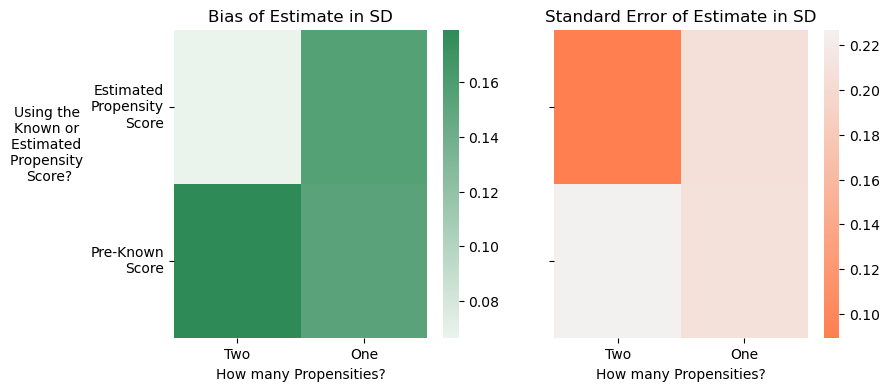

<Figure size 640x480 with 0 Axes>

In [224]:

import seaborn as sns
data_heatmap = pd.pivot_table(data=plot_.loc[(plot_['model']=='PLM')],
                              columns='true_pscore',index='type', values=['abs_bias','SE'])

fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(4.5*2, 4), sharey=True)         # Sample figsize in inches

sns.heatmap(data_heatmap['abs_bias'],
           xticklabels=['Two','One'],
            yticklabels=['Estimated\nPropensity\nScore','Pre-Known\nScore'],
            cmap=sns.light_palette("seagreen", as_cmap=True) ,
           ax=ax[0])
ax[0].set_xlabel('How many Propensities?')
ax[0].set_ylabel('Using the \nKnown or \nEstimated \nPropensity \nScore?', rotation=0, labelpad=30)
ax[0].set_title('Bias of Estimate in SD')
ax[0].set_yticklabels(['Estimated\nPropensity\nScore','Pre-Known\nScore'],rotation=0)

sns.heatmap(data_heatmap['SE'],
           xticklabels=['Two','One'],
            yticklabels=['Estimated\nPropensity\nScore','Pre-Known\nScore'],
            cmap=sns.light_palette("coral", as_cmap=True, reverse=True) ,
           ax=ax[1])
ax[1].set_xlabel('How many Propensities?')
ax[1].set_ylabel('')
ax[1].set_title('Standard Error of Estimate in SD')

plt.yticks(rotation=0) 
# axPres.yaxis.set_label_coords(-0.1,1.02)

plt.show()
plt.tight_layout()


Look at the distribution over model types, whether propensity score is known, and how many propensity scores there are.

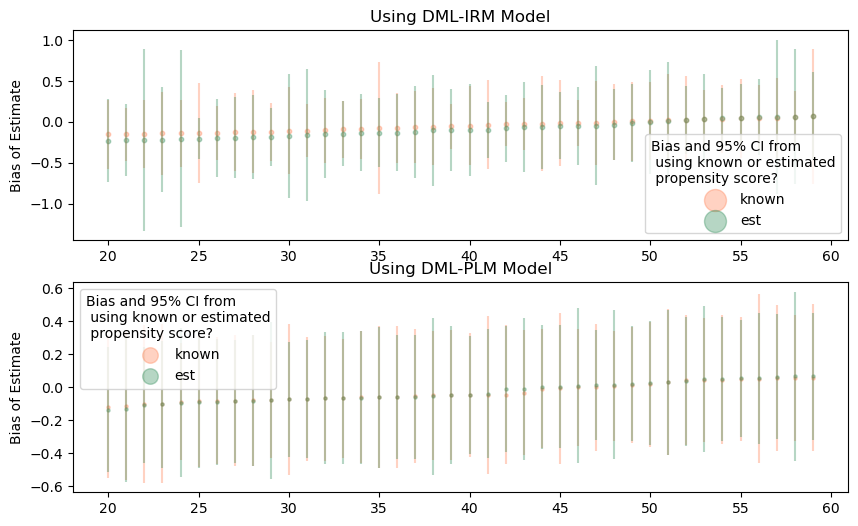

<Figure size 640x480 with 0 Axes>

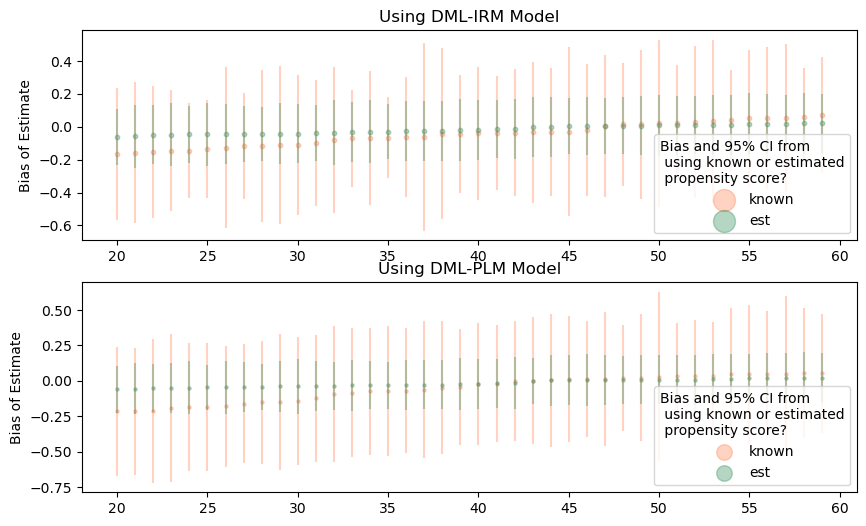

<Figure size 640x480 with 0 Axes>

In [155]:
# for psc in [0.50,0.01]:

for psc in ['same','het']:
    fig,ax = plt.subplots(ncols=1,nrows=2, figsize=(10,6))
    for ty in ['known','est']:
        if ty=='known':
            color='coral'
        else:
            color='seagreen'    
        for t in ['IRM','PLM']:
            data=sim_df.loc[(sim_df['true_pscore']==psc) &\
                        (sim_df['type']==ty) &\
                      (sim_df['model']==t)][['bias','SE']]
            data.sort_values(by='bias',ascending=True, inplace=True)
            data['index']=np.arange(len(data))        

            ## Take the middle couple of observations
            q = int( len(data)/5 )
            data = data[q:3*q]

            if t=='IRM':
                p=ax[0].vlines(x=data['index'], 
                             ymin =data['bias']-1.96*data['SE'],
                            ymax=data['bias']+1.96*data['SE'], alpha=0.35, color=color)

                ax[0].scatter(x=data['index'], y =data['bias'] , s=10, color=p.get_color() , label='{0}'.format(ty))
            else:
                p=ax[1].vlines(x=data['index'], 
                             ymin =data['bias']-1.96*data['SE'],
                            ymax=data['bias']+1.96*data['SE'], alpha=0.35, color=color) 
                ax[1].scatter(x=data['index'], y =data['bias'] ,s = 5, color=p.get_color() , label='{0}'.format(ty))
        ax[0].legend(title='Bias and 95% CI from \n using known or estimated\n propensity score?',
                    markerscale=5)
        ax[0].set_ylabel('Bias of Estimate')
        ax[0].set_title('Using DML-IRM Model')

        ax[1].legend(title='Bias and 95% CI from \n using known or estimated\n propensity score?',
                    markerscale=5)
        ax[1].set_ylabel('Bias of Estimate')
        ax[1].set_title('Using DML-PLM Model')
    plt.show()
    plt.tight_layout()

